In [31]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
%matplotlib inline  


df = pd.read_csv('results_wup_0.8.csv')

# remove rows where no clusters
df = df.dropna(subset=['machine_clusters'])
df = df.dropna(subset=['human_clusters'])
df['success'] = df['hits'] > 0

# How well overall did machine do

T = 0.8, similarity metric is how similar two word senses are, based on the depth of the two senses in the taxonomy and that of their Least Common Subsumer (most specific ancestor node).

In [32]:
df[['human_assessment_type', 'human_clusters', 'machine_clusters', 'success', 'hits']].head(50)


,human_assessment_type,human_clusters,machine_clusters,success,hits
0,tags,"Imagination,Time,Politics","Time,Politics,Materiality",True,2
1,tags,"Imagination,Land","Imagination,Land,Environmental",True,2
2,tags,"Community,Politics,Economy","Land,Materiality,Language",False,0
3,tags,"Imagination,Time,Mind","Materiality,Land,Culture",False,0
4,tags,Immaterial,Immaterial,True,1
5,tags,"Body,Immaterial","Body,Identity,Immaterial",True,2
6,tags,Immaterial,Immaterial,True,1
7,tags,Materiality,"Materiality,Land,Culture",True,1
8,tags,"Technology,Body,Mind","Technology,Language,Body",True,2
9,tags,"Environment,Body","Environmental,Land,Body",True,1


# How well did machine do by human assessment type

In [33]:
df = df[['human_assessment_type', 'human_clusters', 'machine_clusters', 'hits']]
df.groupby('human_assessment_type').agg({'hits':sum}).head()

,hits
human_assessment_type,
description,15
tags,28


In [66]:
df_desc = df.loc[df['human_assessment_type'] == 'description']
df_tags = df.loc[df['human_assessment_type'] == 'tags']

Conclusion from the above is that the machine agrees much more often when the human clustered the works from the tags (vs descriptions).

# human cluster distribution

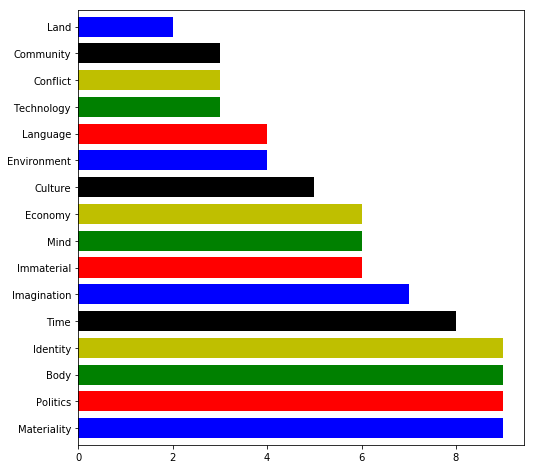

In [74]:
df['human_clusters'].str.split(',', expand=True).head(50)
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
pd.concat([pd.Series(row['human_clusters'].split(','))              
                    for _, row in df.iterrows()]).reset_index()[0]\
    .value_counts().plot(kind='barh', figsize=(8,8), colors=my_colors, width=0.75);

# machine cluster distribution

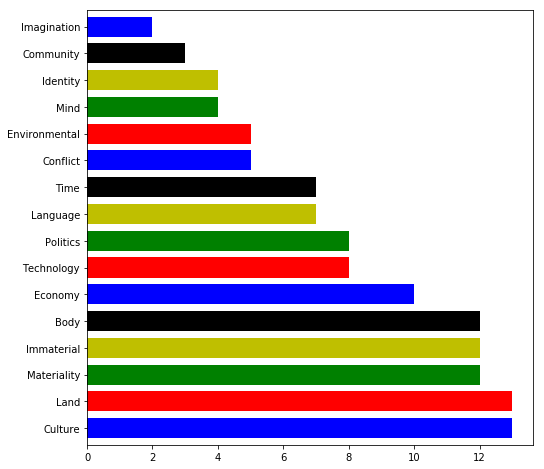

In [73]:
pd.concat([pd.Series(row['machine_clusters'].split(','))              
                    for _, row in df.iterrows()]).reset_index()[0]\
    .value_counts().plot(kind='barh', figsize=(8,8), colors=my_colors, width=0.75);

## which clusters did the machine get it rigth for most?

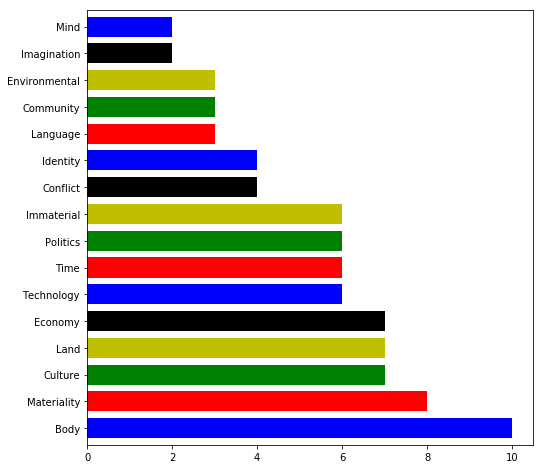

In [72]:
s = df.loc[df['hits'] > 0]['machine_clusters'].str.split(',').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.value_counts().plot(kind='barh', figsize=(8,8), colors=my_colors, width=0.75);


## and which cluster did the machine get it *wrong* for most?


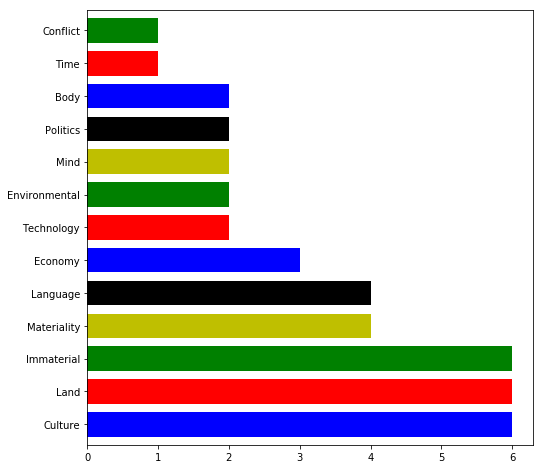

In [71]:
s = df.loc[df['hits']==0]['machine_clusters'].str.split(',').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.value_counts().plot(kind='barh', figsize=(8,8), colors=my_colors, width=0.75);
